In [3]:
# Temporarilly add parent folder to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import time
from statistics import mean, stdev

from base.distance_grid import DistanceGrid
from algorithms.binary_tree import BinaryTree

import pathfinders.dijkstra as Dijkstra
import pathfinders.longest_path as LongestPath
from demos.demo_utils import ALGORITHMS

In [4]:
tries = 100
rows = 10
cols = 10
size = rows*cols

In [5]:
algorithm_averages = {}
algorithm_benchmarks = {}
pathfinding_benchmarks = {}
   
print("Rows: {}\ncolumns: {}\nTotal cells: {}\nRuns per algorithm: {}".format(rows, cols, size, tries))
for algorithm in ALGORITHMS:
    print("> running {}".format(algorithm.__name__))

    pathfinding_timings = []
    timings = []
    deadend_counts = []
    for _ in range(tries):
        grid = DistanceGrid(rows, cols)

        time_start = time.perf_counter()
        algorithm().on(grid)
        time_end = time.perf_counter()

        deadend_counts.append(len(grid.deadends))
        timings.append(time_end - time_start)

        # Pathfiding
        time_start = time.perf_counter()
        start_row, start_column, end_row, end_column = LongestPath.calculate(grid)
        grid = Dijkstra.calculate_distances(grid, start_row, start_column, end_row, end_column)
        time_end = time.perf_counter()
        pathfinding_timings.append(time_end - time_start)

    total_deadends = sum(deadend_counts)
    algorithm_averages[algorithm] = total_deadends / len(deadend_counts)
    timings = [1e3*x for x in sorted(timings)]
    algorithm_benchmarks[algorithm] = {
        "min": timings[0],
        "max": timings[-1],
        "average": mean(timings),
        "std": stdev(timings)
    }
    
    pathfinding_timings = [1e3*x for x in sorted(pathfinding_timings)]
    pathfinding_benchmarks[algorithm] = {
    "min": pathfinding_timings[0],
    "max": pathfinding_timings[-1],
    "average": mean(pathfinding_timings),
    "std": stdev(pathfinding_timings)
    }

sorted_averages = sorted(algorithm_averages.items(), key=lambda x: -x[1])
sorted_benchmarks = sorted(algorithm_benchmarks.items(), key=lambda x: -x[1]["average"])
sorted_pathfinding_benchmarks = sorted(pathfinding_benchmarks.items(), key=lambda x: -x[1]["average"])

Rows: 10
columns: 10
Total cells: 100
Runs per algorithm: 100
> running AldousBroder
> running BinaryTree
> running HuntAndKill
> running RecursiveBacktracker
> running Sidewinder
> running Wilson


In [6]:
print("\nAverage dead-ends (deadends/total-cells, sorted by % desc):")
for algorithm, average in sorted_averages:
    percentage = average * 100.0 / size
    print(" {:>22}: {:03.0f}/{:03d} ({:.2f}%)".format(algorithm.__name__, average, size, percentage))

print("\nGeneration speed benchmark (milliseconds, sorted by average desc):")
for algorithm, benchmark in sorted_benchmarks:
    print(" {:>22}: avg: {:03.6f} min: {:03.6f} max: {:03.6f}".format(algorithm.__name__, benchmark["average"],
          benchmark["min"], benchmark["max"]))

print("\nPathfinding speed benchmark (milliseconds, sorted by average desc):")
for algorithm, benchmark in sorted_pathfinding_benchmarks:
    print(" {:>22}: avg: {:03.6f} min: {:03.6f} max: {:03.6f}".format(algorithm.__name__, benchmark["average"],
          benchmark["min"], benchmark["max"]))


Average dead-ends (deadends/total-cells, sorted by % desc):
                 Wilson: 029/100 (29.11%)
           AldousBroder: 029/100 (29.09%)
             Sidewinder: 028/100 (27.72%)
             BinaryTree: 026/100 (26.12%)
   RecursiveBacktracker: 012/100 (11.97%)
            HuntAndKill: 012/100 (11.50%)

Generation speed benchmark (milliseconds, sorted by average desc):
                 Wilson: avg: 30.726975 min: 10.813454 max: 108.264209
           AldousBroder: avg: 7.785143 min: 3.304173 max: 22.387191
            HuntAndKill: avg: 4.562988 min: 2.207373 max: 11.274731
   RecursiveBacktracker: avg: 1.339825 min: 0.995039 max: 4.852091
             BinaryTree: avg: 0.748576 min: 0.654121 max: 1.941162
             Sidewinder: avg: 0.488508 min: 0.362179 max: 1.647137

Pathfinding speed benchmark (milliseconds, sorted by average desc):
   RecursiveBacktracker: avg: 2.271306 min: 1.665408 max: 3.965663
            HuntAndKill: avg: 2.193998 min: 1.606060 max: 8.437690
        

In [7]:
import matplotlib.pyplot as plt
import numpy as np

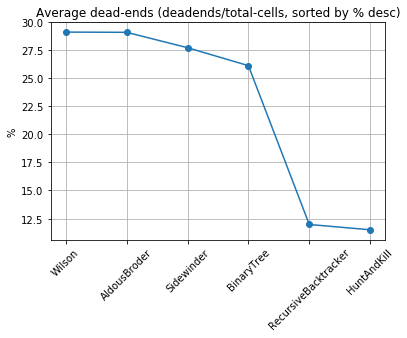

In [8]:
sorted_averages_zip = list(zip(*sorted_averages))
dead_ends = [x*100.0/size for x in sorted_averages_zip[1]]
names = [x.__name__ for x in sorted_averages_zip[0]]
x = range(len(names))

plt.plot(x, dead_ends, 'o-')
plt.title('Average dead-ends (deadends/total-cells, sorted by % desc)')
plt.ylabel('%')
plt.xticks(x, names, rotation=45)
plt.grid()
plt.show()

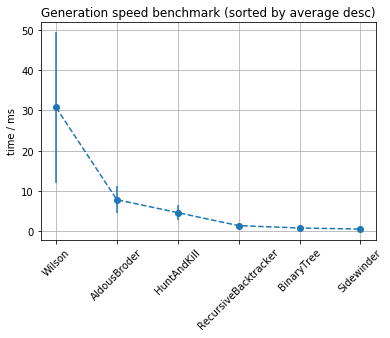

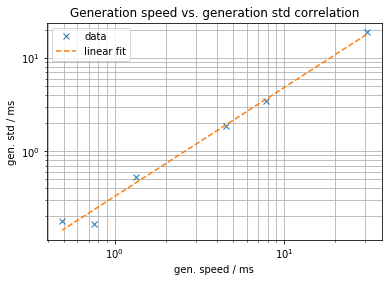

In [9]:
sorted_generation_benchmarks_zip = list(zip(*sorted_benchmarks))
generation_names = [x.__name__ for x in sorted_generation_benchmarks_zip[0]]
generation_averages = [x['average'] for x in sorted_generation_benchmarks_zip[1]]
generation_stds = [x['std'] for x in sorted_generation_benchmarks_zip[1]]
x = range(len(names))

plt.errorbar(x, generation_averages, yerr=generation_stds, fmt='--o')
plt.title('Generation speed benchmark (sorted by average desc)')
plt.ylabel('time / ms')
plt.xticks(x, generation_names, rotation=45)
plt.grid()
plt.show()

x = generation_averages
y = generation_stds
fit = np.polyfit(np.log10(x),np.log10(y),1)
fit_fn = lambda x: 10**fit[1]*x**fit[0]

plt.loglog(x,y,'x',x,fit_fn(x),'--')
plt.title('Generation speed vs. generation std correlation')
plt.xlabel('gen. speed / ms')
plt.ylabel('gen. std / ms')
plt.legend(['data','linear fit'])
plt.grid(b=None,which='both')
plt.show()

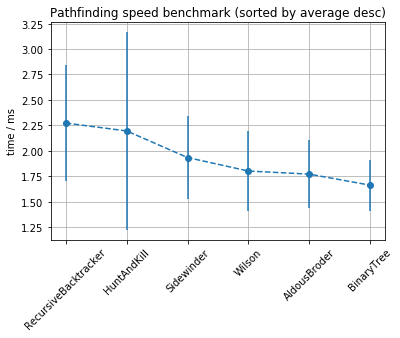

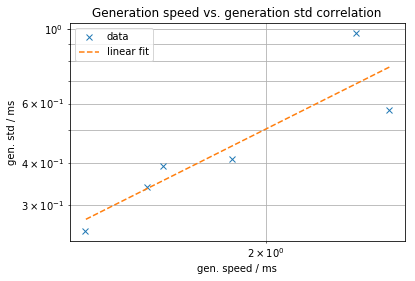

In [10]:
sorted_pathfinding_benchmarks_zip = list(zip(*sorted_pathfinding_benchmarks))
pathfinding_names = [x.__name__ for x in sorted_pathfinding_benchmarks_zip[0]]
pathfinding_averages = [x['average'] for x in sorted_pathfinding_benchmarks_zip[1]]
pathfinding_stds = [x['std'] for x in sorted_pathfinding_benchmarks_zip[1]]

x = range(len(names))
plt.errorbar(x, pathfinding_averages, yerr=pathfinding_stds, fmt='--o')
plt.title('Pathfinding speed benchmark (sorted by average desc)')
plt.ylabel('time / ms')
plt.xticks(x, pathfinding_names, rotation=45)
plt.grid()
plt.show()

x = pathfinding_averages
y = pathfinding_stds
fit = np.polyfit(np.log10(x),np.log10(y),1)
fit_fn = lambda x: 10**fit[1]*x**fit[0]

plt.loglog(x,y,'x',x,fit_fn(x),'--')
plt.title('Generation speed vs. generation std correlation')
plt.xlabel('gen. speed / ms')
plt.ylabel('gen. std / ms')
plt.legend(['data','linear fit'])
plt.grid(b=None,which='both')
plt.show()